In [1]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# !pip install opencv-python
# !apt update && apt install -y libsm6 libxext6
# !apt-get install -y libxrender-dev

In [1]:
import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 29.1 GB  |     Proc size: 54.0 MB
GPU RAM Free: 8125MB | Used: 1MB | Util   0% | Total     8126MB


In [2]:
from pathlib import Path
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import random
import cv2
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
import ast

In [3]:
CUDA_LAUNCH_BLOCKING=1

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
#!unzip /content/gdrive/My\ Drive/frames_resized.zip

In [6]:
import sys
sys.path.append("..")

In [7]:
!ls

download-data.ipynb  logo_resnet.ipynb		  transform-data.ipynb
fecht-data.ipynb     logo_resnet_COLAB.ipynb
generate-anno.ipynb  logo_resnet_COLAB_old.ipynb


In [8]:
from sklearn import preprocessing
import os
import glob

def concatenate_anno(path):

    le = preprocessing.LabelEncoder()
    list_data = []

    df = pd.DataFrame()
    for root,dirs,_ in os.walk(path):
        for d in dirs:
            path_sub = os.path.join(root,d) # this is the current subfolder
            for filename in glob.glob(os.path.join(path_sub, '*.csv')):
                print(filename)
                if os.path.split(filename)[1] == 'datos.csv':
                    print(f'Concatenating {filename}')
                    #df = pd.concat([df, pd.read_csv(filename, index_col=[0])])
                    list_data.append(filename)
                    #df = pd.concat([df, pd.read_json(filename)])
                    #infile = open(filename,'rb')
                    #list_data.append(pickle.load(infile))
                    #df = pd.concat([df, pd.DataFrame(pickle.load(infile))])

    df = pd.concat([pd.read_csv(x).reset_index(drop=True) for x in list_data], axis=0)
    print(df.columns)
    if len(df) >  0:
        if 'class' in df.columns:
            df['class'] = le.fit_transform(df['class'])
        else:
            raise ValueError("Column 'class' not found")
        #df['category'] = video_category
        print(f'Data concatenated. {len(df)} annotations were appended')
    else:
        raise ValueError("No annotations found")
    
    return df


data = concatenate_anno('../data')

../data/EmZtTd1YRmA/datos.csv
Concatenating ../data/EmZtTd1YRmA/datos.csv
../data/2femix89pTE/datos.csv
Concatenating ../data/2femix89pTE/datos.csv
../data/R-Yq1AlIwsc/datos.csv
Concatenating ../data/R-Yq1AlIwsc/datos.csv
../data/TB5yhZdF8SI/datos.csv
Concatenating ../data/TB5yhZdF8SI/datos.csv
Index(['Unnamed: 0', 'filename', 'widht', 'height', 'class', 'xmin', 'ymin',
       'xmax', 'ymax', 'new_path', 'new_bb', 'img_data'],
      dtype='object')
Data concatenated. 21164 annotations were appended


In [9]:
#data = pd.read_csv('data.csv', index_col=[0])
data.head()

,Unnamed: 0,filename,widht,height,class,xmin,ymin,xmax,ymax,new_path,new_bb,img_data
0,0,data/video-files/F1/EmZtTd1YRmA/input/frames/f...,0.0,0.0,59,0.0,0.0,0.0,0.0,data/video-files/F1/EmZtTd1YRmA/input/frames_r...,[0. 0. 0. 0.],NaN
1,1,data/video-files/F1/EmZtTd1YRmA/input/frames/f...,153.0,47.0,30,83.0,985.0,236.0,1032.0,data/video-files/F1/EmZtTd1YRmA/input/frames_r...,[273. 19. 286. 54.],NaN
2,1,data/video-files/F1/EmZtTd1YRmA/input/frames/f...,543.0,179.0,98,770.0,0.0,1313.0,179.0,data/video-files/F1/EmZtTd1YRmA/input/frames_r...,[ 0. 179. 49. 305.],NaN
3,1,data/video-files/F1/EmZtTd1YRmA/input/frames/f...,506.0,176.0,98,12.0,5.0,518.0,181.0,data/video-files/F1/EmZtTd1YRmA/input/frames_r...,[ 1. 3. 49. 120.],NaN
4,1,data/video-files/F1/EmZtTd1YRmA/input/frames/f...,134.0,48.0,98,1736.0,555.0,1870.0,603.0,data/video-files/F1/EmZtTd1YRmA/input/frames_r...,[154. 404. 167. 434.],NaN


In [10]:
data = data[data['class']!=59]
#data['class'] = data['class'].apply(lambda x: 24 if x==32 else x)

In [11]:
len(data)

18723

In [12]:
def get_list(x):
    x = x.replace('.', '.0,')
    x = ast.literal_eval(x)
    return np.array(x, dtype=np.float32)

del data['Unnamed: 0']
del data['img_data']
data['new_bb'] = data['new_bb'].apply(get_list)
data['new_path'] = data['filename'].map(lambda x: x.replace('data', '../data').replace('video-files/F1/', '').replace('input/', ''))

In [13]:
data.head()

,filename,widht,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
1,data/video-files/F1/EmZtTd1YRmA/input/frames/f...,153.0,47.0,30,83.0,985.0,236.0,1032.0,../data/EmZtTd1YRmA/frames/frame1.jpg,"[273.0, 19.0, 286.0, 54.0]"
2,data/video-files/F1/EmZtTd1YRmA/input/frames/f...,543.0,179.0,98,770.0,0.0,1313.0,179.0,../data/EmZtTd1YRmA/frames/frame1.jpg,"[0.0, 179.0, 49.0, 305.0]"
3,data/video-files/F1/EmZtTd1YRmA/input/frames/f...,506.0,176.0,98,12.0,5.0,518.0,181.0,../data/EmZtTd1YRmA/frames/frame1.jpg,"[1.0, 3.0, 49.0, 120.0]"
4,data/video-files/F1/EmZtTd1YRmA/input/frames/f...,134.0,48.0,98,1736.0,555.0,1870.0,603.0,../data/EmZtTd1YRmA/frames/frame1.jpg,"[154.0, 404.0, 167.0, 434.0]"
5,data/video-files/F1/EmZtTd1YRmA/input/frames/f...,145.0,67.0,98,1144.0,441.0,1289.0,508.0,../data/EmZtTd1YRmA/frames/frame1.jpg,"[122.0, 266.0, 140.0, 299.0]"


In [14]:
def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = np.random.uniform(0, 1)
    rand_c = np.random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))
    
def read_image(filename): return mpimg.imread(filename)

In [15]:
from sklearn.model_selection import train_test_split
X = data[['xmin', 'ymin', 'xmax', 'ymax', 'new_path', 'new_bb']]
Y = data['class']

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
num_classes = len(set(Y))

In [17]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [18]:
class RoadDataset():
    def __init__(self, paths, bb, y, transforms=False):
        self.transforms = transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb
    
# class RoadDataset():
#     def __init__(self, paths, bb, y, transforms=False):
#         self.transforms = transforms
#         self.paths = paths.values
#         self.bb = bb.values
#         self.y = y.values
#     def __len__(self):
#         return len(self.paths)
    
#     def __getitem__(self, idx):
#         path = self.paths[idx]
#         y_class = self.y[idx]
#         x, y_bb = transformsXY(path, self.bb[idx], self.transforms)
#         x = normalize(x)
#         x = np.rollaxis(x, 2)
#         return x, y_class, y_bb

In [19]:
train_ds = RoadDataset(X_train['new_path'],X_train['new_bb'] ,y_train, transforms=True)
valid_ds = RoadDataset(X_val['new_path'],X_val['new_bb'],y_val)

In [20]:
from torch.utils.data import Dataset, DataLoader

batch_size = 16
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [21]:
from torch import nn
import torchvision.models as models


class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, num_classes))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [22]:
def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [23]:
def train_epocs(model, optimizer, train_dl, val_dl, epochs=10,C=1000):
    idx = 0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, y_class, y_bb in train_dl:
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
            loss_bb = loss_bb.sum()
            loss = loss_class + loss_bb/C
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            idx += 1
            total += batch
            sum_loss += loss.item()
        train_loss = sum_loss/total
        val_loss, val_acc = val_metrics(model, valid_dl, C)
        print("train_loss %.3f val_loss %.3f val_acc %.3f" % (train_loss, val_loss, val_acc))
    return sum_loss/total

In [24]:
def val_metrics(model, valid_dl, C=1000):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y_class, y_bb in valid_dl:
        batch = y_class.shape[0]
        x = x.cuda().float()
        y_class = y_class.cuda()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
        loss_bb = F.l1_loss(out_bb, y_bb, reduction="none").sum(1)
        loss_bb = loss_bb.sum()
        loss = loss_class + loss_bb/C
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += loss.item()
        total += batch
    return sum_loss/total, correct/total

In [25]:
import torch
model = BB_model().cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.004)

In [26]:
import torch.nn.functional as F
train_epocs(model, optimizer, train_dl, valid_dl, epochs=10)

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [38]:
data.values[0][-2]

'../data/EmZtTd1YRmA/frames/frame0.jpg'

In [29]:
num_classes

100

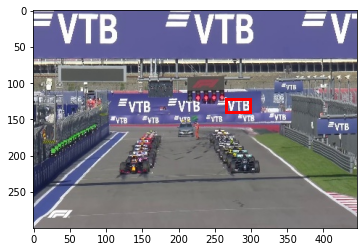

In [39]:
#original
frame = str(data.values[10][-2])
im = cv2.imread(frame)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, data.values[10][-1])

In [40]:
# resizing test image
im = read_image(frame)
im = cv2.resize(im, (int(1.49*300), 300))
cv2.imwrite(frame, cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

In [368]:
# test Dataset
test_ds = RoadDataset(pd.DataFrame([{'path':frame}])['path'],pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],pd.DataFrame([{'y':[0]}])['y'])
x, y_class, y_bb = test_ds[0]

In [61]:
xx = torch.FloatTensor(x[None,])
xx.shape

torch.Size([1, 3, 284, 423])

In [62]:
# prediction
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[  0.9999,  -7.9939, -15.8801,   2.9928, -11.0146,  -1.8281,  -3.5767,
          -10.5667,  -4.5197,   2.6493,   1.9368,  -6.5460,   1.7192,   3.3106,
           -6.7393,   2.3611,   6.1967,   4.2918,  -7.4719,   0.2239,  -4.0652,
            1.2341,  -9.8202, -12.9261,   1.9541,  -5.3757,  -5.6182,  -8.8926,
           10.0254,  -9.4075,  -3.3164,   0.3506]], device='cuda:0',
        grad_fn=<AddmmBackward>),
 tensor([[ 17.6212, 197.1440,  39.8469, 211.0516]], device='cuda:0',
        grad_fn=<AddmmBackward>))

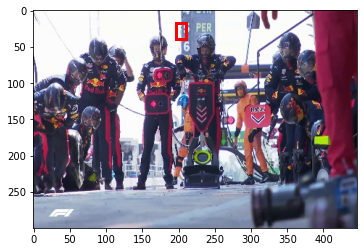

In [63]:
# predicted bounding box
bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])

In [41]:
data.head()

,filename,widht,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
1425,../data/F1 Hamilton/input/frames/frame3.jpg,41,46,16,698,437,739,483,frames_resized/frame3.jpg,"[121.0, 162.0, 133.0, 171.0]"
1426,../data/F1 Hamilton/input/frames/frame6.jpg,41,46,16,701,440,742,486,frames_resized/frame6.jpg,"[122.0, 163.0, 134.0, 172.0]"
1427,../data/F1 Hamilton/input/frames/frame8.jpg,42,46,16,703,444,745,490,frames_resized/frame8.jpg,"[123.0, 164.0, 135.0, 173.0]"
903,../data/F1 Hamilton/input/frames/frame8.jpg,54,75,27,1665,552,1719,627,frames_resized/frame8.jpg,"[153.0, 388.0, 173.0, 399.0]"
1428,../data/F1 Hamilton/input/frames/frame11.jpg,44,46,16,705,442,749,488,frames_resized/frame11.jpg,"[123.0, 164.0, 135.0, 173.0]"
